In [1]:
import os
import pandas as pd
import numpy as np
from utils import its, plotline, plot_dual_indices

FP = '../data/nyt_1987_2007_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .rename(columns={'Publication Date': 'date'})
      .assign(date=lambda df: pd.to_datetime(df.date),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )
      .query('terms>20').query('terms<2430') # cut bottom and top 1 percent
      .groupby(['mthyr']).mean().reset_index()
     )
df.head(3)

,mthyr,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,year
0,1987-01-01,48.717209,14.594214,15.771672,10.421421,471.127588,203.994404,0.462579,74.870665,0.782030,1.0,1987.0
1,1987-02-01,48.178742,14.802379,16.000572,10.397997,477.782868,206.633923,0.464431,75.715691,0.782139,2.0,1987.0
2,1987-03-01,50.896111,13.484912,14.643084,11.147658,509.313379,221.944206,0.466883,79.469068,0.796205,3.0,1987.0


<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

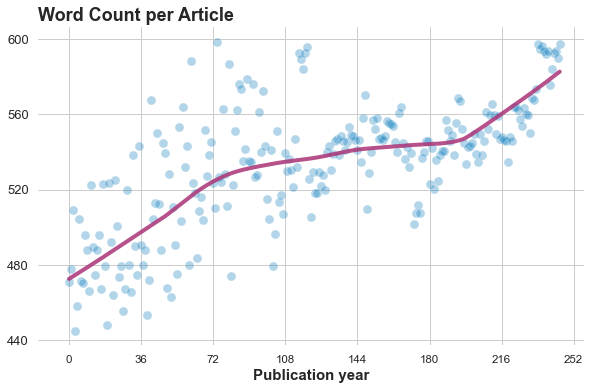

In [3]:
plotline(x=df.index, y=df.terms, yrange=range(440,640,40), title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'nyt_wordcount'))    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

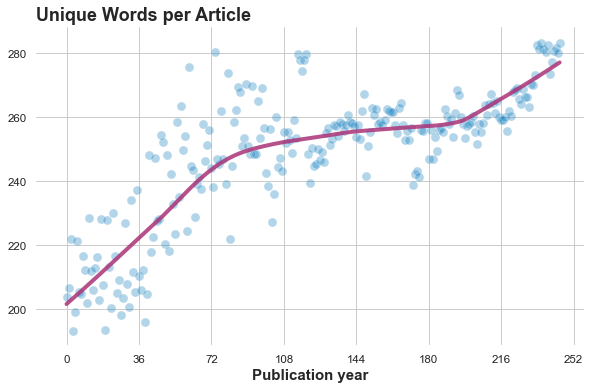

In [4]:
plotline(x=df.index, y=df.uniqueterms, title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'nyt_uniquewords'))    

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

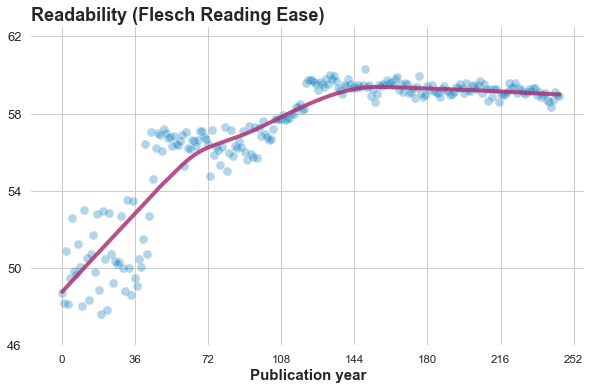

In [5]:
plotline(x=df.index, y=df.flesch_reading_ease, yrange=range(46,66,4), title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'nyt_readability_flesch_ease'))    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

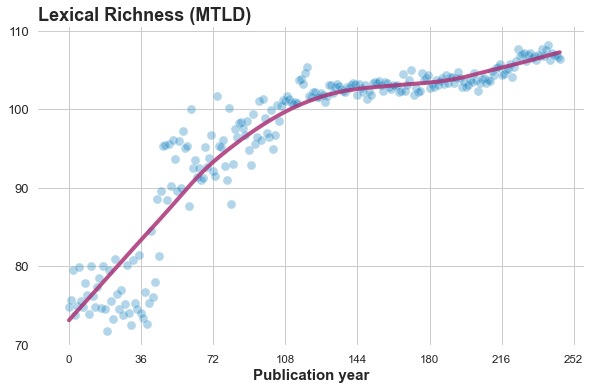

In [6]:
plotline(x=df.index, yrange=range(70,120,10), y=df.mtld, title='Lexical Richness (MTLD)', 
         savepath=os.path.join(SAVEPATH, 'nyt_lexicalrichness_mtld'))    

In [7]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
      .rename(columns={'Publication Date': 'date'})
      .assign(date=lambda df: pd.to_datetime(df.date),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )
      .query('terms>20').query('terms<2430') # cut bottom and top 1 percent
      .groupby(['year']).mean().reset_index()
      .assign(
          iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
          ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
          imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
          ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
          iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
          iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
             )
     )
idf.head(3)

,year,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,1987,49.746652,14.175292,15.348539,10.489351,479.760194,208.707269,0.466073,76.170924,0.787199,5.869201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1988,50.289658,13.987313,15.175920,10.555076,487.974116,211.988633,0.465553,76.261652,0.789601,6.486947,1.091543,0.626591,0.119111,-0.111574,1.712089,1.572233
2,1989,50.587130,13.868594,15.060067,10.619936,489.019685,212.371025,0.466691,76.194635,0.790414,6.466339,1.689518,1.244933,0.031129,0.132421,1.930025,1.755452


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change from 1987'>

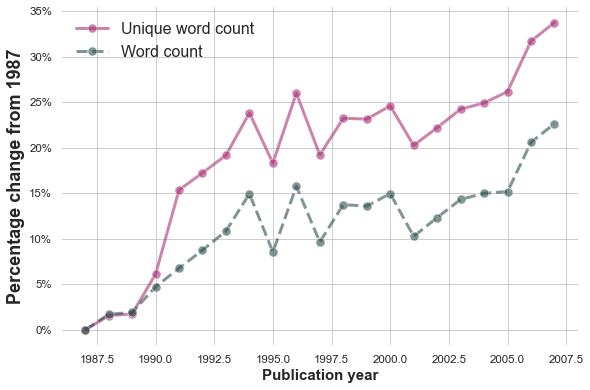

In [8]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, 
                  label1='Unique word count', label2='Word count', title='',
                  savepath=os.path.join(SAVEPATH, 'nyt_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

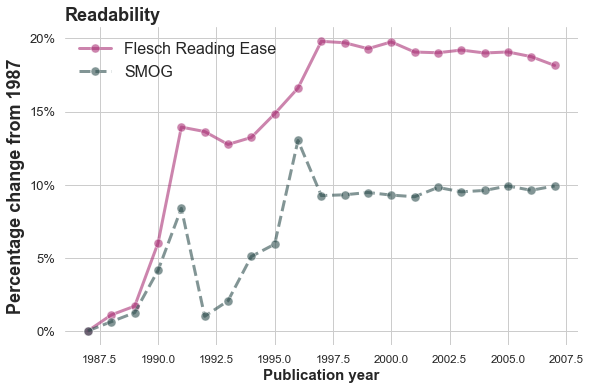

In [9]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog, yrange=range(0,25,5), 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  savepath=os.path.join(SAVEPATH, 'nyt_readability_index'))    

<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

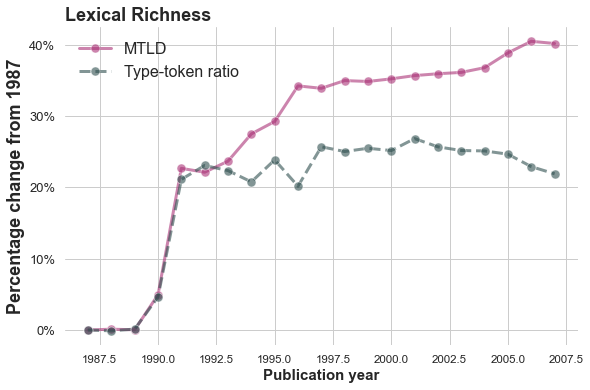

In [10]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, yrange=range(0,50,10), 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  savepath=os.path.join(SAVEPATH, 'nyt_lexicalrichness_index'))    